In [132]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sps
import pandas as pd
from astropy.io import fits
import scipy.interpolate as spinterp
import scipy.integrate as spint
from lmfit.minimizer import Minimizer
import lmfit
from lmfit import Minimizer, Parameters, report_fit
import emcee
import corner
from multiprocess import Pool
import matplotlib.ticker as ticker
import scipy 


In [2]:
# Load the data from the FITS file given. 
dr3stars = fits.open('gaiadr3_cluster_stars.fits')
dr3stars.info()
print(dr3stars[1].columns)
stars = pd.DataFrame(dr3stars[1].data)
stars['Name'] = stars['Name'].str.strip()

clcounts = stars.groupby(['Name']).size().reset_index(name='count')
# Select given cluster 'FoF_2117'
cluster_data = stars[stars['Name'] == 'FoF_2117']

Filename: gaiadr3_cluster_stars.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      93   ()      
  1  members.dat    1 TableHDU       331   1291929R x 56C   [A20, I4, I19, I1, F10.8, F12.8, F10.8, F12.8, F10.8, F12.8, E11.4, E11.4, F10.8, E11.4, F10.8, E11.4, F10.8, F11.8, F11.8, E11.4, E11.4, E11.4, E11.4, E11.4, E11.4, I2, F12.8, F10.7, F11.8, F10.8, F19.8, F16.8, F18.8, F17.8, F18.8, F17.8, F10.7, F10.7, F10.7, E11.4, E11.4, E11.4, E9.3, F12.8, F4.1, F6.1, F5.1, F11.7, F11.8, F6.1, F12.7, F13.8, F5.1, A13, I1, I1]   
ColDefs(
    name = 'Name'; format = 'A20'; start = 1
    name = 'ID'; format = 'I4'; disp = 'I4'; start = 22
    name = 'GaiaDR3'; format = 'I19'; disp = 'I19'; start = 27
    name = 'inrt'; format = 'I1'; disp = 'I1'; start = 47
    name = 'Prob'; format = 'F10.8'; disp = 'F10.8'; start = 49
    name = 'RAdeg'; format = 'F12.8'; unit = 'deg'; disp = 'F12.8'; start = 60
    name = 'e_RAdeg'; format = 'F10.8'; unit = 

NOTE:
* For the generation of the dockstrings inside some functions I used the help of AI, in order to avoid wasting time.

# Question 1

### Brief Explanation 

The code below presents an analysis of the assigned cluster based on the Bayes' theorem for the calculation of the posterior pdf for the distance d in kpc. Firstly, we calculated the distance of each individual star through the parallax relation considering the appropriate correction of 0.029 mas to the parallax measurements. For the case of a uniform prior of the distance p(d) and a normal distribution of the likelihood p(D|d), the posterior pdf for d was returned as a plot though a function using the following equation:

$ P(d|D) = \frac{P(D|d) P(d)}{P(D)} $

where D is the given data and d the distance of the stars. Furthermore, the normalisation was implemented in the equation though the integration of the numerator over the distance (corresponding to the evidence).

In the same function the posterior pdf was compared to a Gaussian distribution using the weighted mean parallax method (wt_mean_err). In the final plot the 1-sigma intervals were included, calculated using cumulative distribution function (cdf) of the posterior. Another characteristic included in the plot was distance corresponding to the mode of the posterior pdf.

### Assumptions 

The following assumptions were considered for the execution of this exercise:
- The measurements of the parallax are normally distributed with standard deviations in the data.
- Bayesian distriburion for the distance, prior 'belief' in the outcome. The uniform prior indicates that all values within the specified range are equally likely before any data is observed (no prior preference or bias)
- dependence between the observed data and the inferred distance
 

### Results 

Based on the results, the mode of the posterior pdf for the distance, with a uniform prior, is calculated as 1.558 kpc, and the Gaussian-weighted mean distance yields the same value, indicating strong agreement between the two approaches. The 1-sigma interval for the distance, derived from the Bayesian posterior, is [1.552, 1.564] kpc, suggesting a high degree of precision in the distance estimate approximately 1% of the range.  This analysis demonstrates the utility of the Bayesian method in distance estimates while incorporating observational uncertainties and prior knowledge. On the other hand, the gaussian distribution represents the Frequentist approach of the model using the weighted mean parallax model. The two models seem to converge in this particular case considering the demostrated plot. This can be justified by the fact that here we have a uniform prior and the bayesian psterior pdf is dominated by the likelihood, resulting in the agreement of the two models especially since we have a large dataset. Also, the large number of independent measurements, which, according to the Central Limit Theorem, ensure that the generated posterior will converge to the normal distribution. 


In [119]:
def wt_mean_err(x,xerr):
    '''Returns the weighted mean and weighted error on the mean for input data array x with
    errors xerr'''
    weights = xerr**(-2)
    sum_weights = np.sum(weights)
    wtmean = np.sum(weights*x)/sum_weights
    wterr = sum_weights**(-0.5)
    return wtmean, wterr

def posterior_fun(stars_plx, e_plx, dist_arr, prior_dis = 'uniform'):
    """
    Calculate the posterior probability density function (pdf) of distances
    using Bayesian inference, based on parallax measurements and specified priors.

    Inputs:
    stars_plx : array
        An array of parallax measurements for stars (in mas).
    e_plx : array
        An array of uncertainties associated with the parallax measurements.
    dist_arr : array
        An array of distance values (in kpc) over which the posterior pdf is calculated.
    prior_dis : str
        - 'uniform': Uniform prior over the distance range.
        - 'exp': Exponential prior proportional to d^2 * exp(-d).

    Output:
    posterior_pdf : array
        The calculated posterior probability density function over the d.
    int95 : array
        The 95% confidence interval for the distance (in kpc).
    max_likelihood_position : float
        The distance value (in kpc) corresponding to the maximum posterior probability.

    """

    x = stars_plx.reshape(len(stars_plx),1)
    scale = e_plx.reshape(len(x), 1)
    loc = 1/(dist_arr.reshape(1, len(dist_arr)))
    
    # Calculation of priors depending on the argument given 
    if prior_dis == 'uniform':
        prior = 1 / (np.max(dist_arr)-np.min(dist_arr))

    elif prior_dis == 'exp':
        prior = (dist_arr)**2 * np.exp(-dist_arr)
        
    else: 
        print('Define prior_dis with either a normal(exp) or an expodential distribution(exp)' )

    # Sum the individual log-likelihoods and also the log(prior)
    loglikel_ln = np.sum(sps.norm.logpdf(x, scale=scale, loc=loc), axis=0)+ np.log(prior)
    likel_prior = np.exp(loglikel_ln-np.amax(loglikel_ln))

    # Calculate evidence 
    likel_prior_int = spint.simpson(likel_prior,dist_arr,axis=0)

    # Calculate the posterior pdf
    posterior_pdf = likel_prior/likel_prior_int
        
    # Find Maximum Likelihood Position
    max_likelihood_position = dist_arr[np.argmax(posterior_pdf)]

    # Confidence interval from posterior 
    posterior_cdf = spint.cumulative_trapezoid(posterior_pdf,dist_arr,initial=0)
    posterior_ppf = spinterp.interp1d(posterior_cdf,dist_arr)

    # Calculate 95% confidence interval. The range must be 0.95, centred on 0.5 (the median)
    int95 = posterior_ppf([0.16,0.84])
    
    # Print the confidence interval
    print(r'1-sigma interval on d =',int95)
    print("The maximum likelihood position is (Kpc):", max_likelihood_position)

    return posterior_pdf, int95, max_likelihood_position


1-sigma interval on d = [1.55504916 1.56125123]
The maximum likelihood position is (Kpc): 1.558097996139528
The weighted mean distance is: 1.5581316199567765 ± 0.0031171866912183994


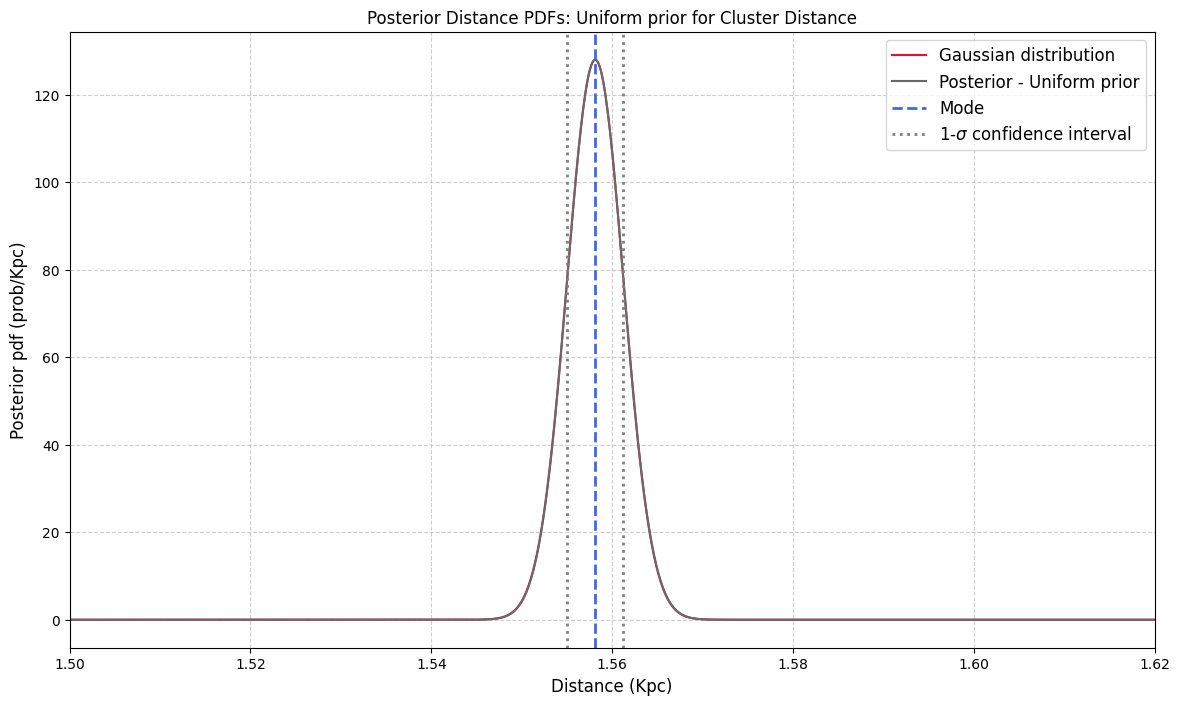

In [163]:
# Select the appropriate data 
plx = cluster_data['Plx'].values
e_plx = cluster_data['e_Plx'].values
gaia_corr = 0.029 # in mas 
stars_plx = plx + gaia_corr # Adding correction factor

# Define the distance grid
dist_arr = np.linspace(1/ np.max(stars_plx), 1 / np.min(stars_plx), 10000)  # Distance in kpc


posterior_pdf, int95, max_likelihood_position = posterior_fun(stars_plx, e_plx, dist_arr, prior_dis = 'uniform')

# Normal distribution using weighted mean + error parallax method
wtmean, wterr = wt_mean_err(stars_plx, e_plx)
norm_values = sps.norm.pdf(dist_arr, loc=1/wtmean, scale=wterr / (wtmean ** 2))
print("The weighted mean distance is:", 1/wtmean, u"\u00B1", wterr / (wtmean ** 2))

# Plot results 
plt.figure(figsize=(14,8))
plt.plot(dist_arr, norm_values , color='crimson', label='Gaussian distribution')
plt.plot(dist_arr,posterior_pdf, color = 'dimgrey', label = 'Posterior - Uniform prior')
plt.axvline(max_likelihood_position, linestyle='dashed', color='royalblue', linewidth=2, label = 'Mode')
plt.axvline(int95[0],color='gray',linestyle='dotted', linewidth=2)
plt.axvline(int95[1],color='gray',linestyle='dotted', linewidth=2, label = r'1-$\sigma$ confidence interval')
plt.xlabel('Distance (Kpc)',fontsize=12)
plt.ylabel(r'Posterior pdf (prob/Kpc)',fontsize=12)
plt.xlim(1.50, 1.62)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6) 
plt.title('Posterior Distance PDFs: Uniform prior for Cluster Distance')
plt.show()


# Question 2

### Brief Explanation 
The same steps were followed for this particular question of the Assignment, with the only difference being the prior distribution, in order to extract the bayesian posterior pdf of the distance. The main assumption here was that the prior pdf decreases with distance based on the following equation:

$ p(d) \propto d e^{-d/L}$ (1)

where L = 1 kpc. The same function was used as question 1, with the likelihood still following a normal distribution, calculated using Bayes' theorem. Similarly, the bayesian posterior was plotted along with the Gaussian distribution using the weighted mean parallax method (wt_mean_err), while still incoporating the 1-sigma intervals. The same process was repeated for the sample size of only 10 random stars of the dataframe.


### Assumptions 

The assumptions below were taken into consideration for the execurion of the code.
- The new prior given by equation (1) a constant volume density of stars with a decrease in density as distance increases, which is consistent with a more physically motivated model for stellar populations. The posterior is influenced by the prior, especially given a small sample size.
- the selection of the N=10 stars is random.
- The measurements of the parallax are normally distributed with standard deviations in the data.
- The measurements of the distance are normally distributed with standard deviations in the data (although the equation d=1/p is non linear with the parallax normal distributed function)
- There is dependence between the observed data and the inferred distance



### Results 

The analysis demonstrates the impact of incorporating a realistic prior, particularly in small-sample scenarios. For the full dataset the posterior pdf with the exponential prior results a mode for the distance identical to the uniform prior, reflecting the influence of the prior's preference for smaller distances. At the same time, the posterior remains in agreement with the Gaussian-weighted mean estimate, as the large number of data points minimizes the influence of the prior. This is expected due to the large number of independent measurements, which, according to the Central Limit Theorem, ensure that the generated posterior will converge to the normal distribution. The 1-sigma interval is the same as with the uniform prior. Regarding the sample of 10 stars the posterior pdf exhibits greater variance, as the reduced dataset provides less information to constrain the distance. Here, the posterior is more strongly influenced by the prior, resulting in a noticeable shift of the mode at 1.498 Kpc toward smaller distances compared to the full dataset. Since, the prior plays a more dominant role, leading to a noticeable difference between the Bayesian posterior and the Gaussian-weighted mean. Furthermore, the 1-sigma interval for the distance was calculated as [1.5521, 1.5643] kpc for the full dataset. The narrow range indicates high precision in the distance estimate, which is expected given the large sample size. For the 10-star random sample, the 1-sigma interval was calculated as [1.4516, 1.5510] kpc, which is noticeably wider and shifted toward smaller distances compared to the full dataset. This highlights the increased uncertainty in the distance estimate when fewer stars are used. Larger datasets provide better constraints on the posterior, allowing for more precise distance estimates.



1-sigma interval on d = [1.55505191 1.56125402]
The maximum likelihood position is (Kpc): 1.558097996139528
The weighted mean distance is: 1.5581316199567765 ± 0.0031171866912183994


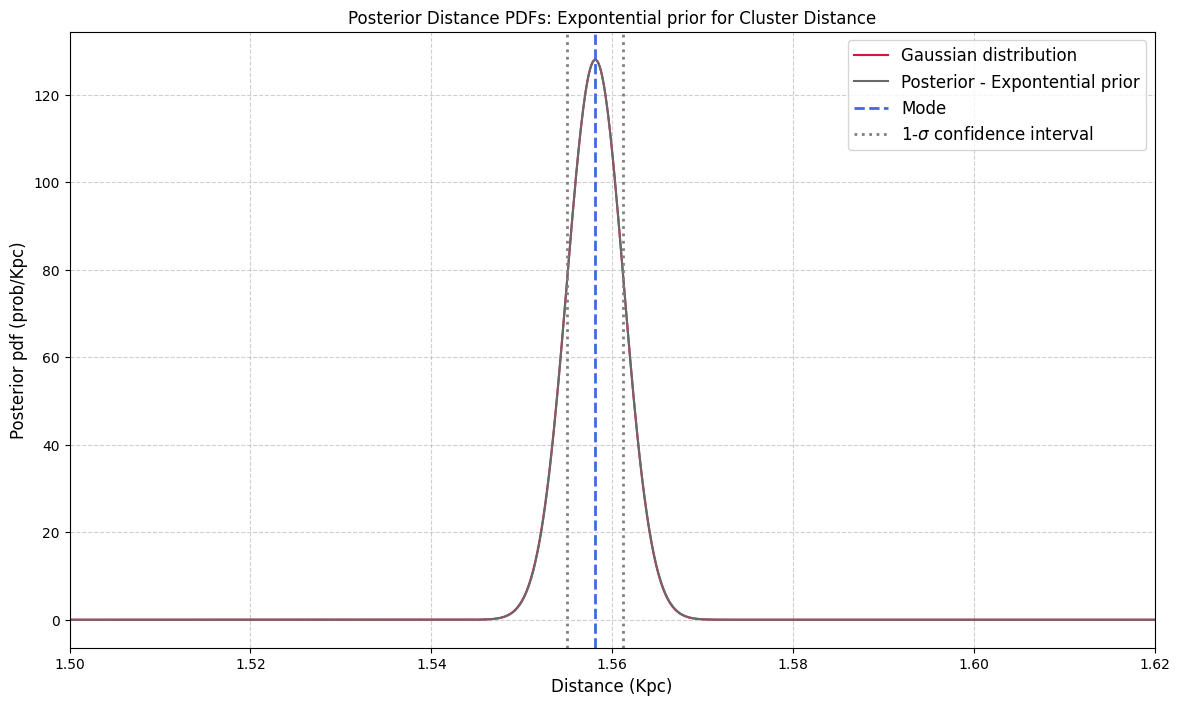

In [164]:
# Call posterior function now for a changed- expontential prior
posterior_pdf_exp, int95_exp, max_likelihood_position_exp = posterior_fun(stars_plx, e_plx, dist_arr, prior_dis = 'exp')

print("The weighted mean distance is:", 1/wtmean, u"\u00B1", wterr / (wtmean ** 2))

# Plot results
plt.figure(figsize=(14,8))
plt.plot(dist_arr, norm_values , color='crimson', label='Gaussian distribution')
plt.plot(dist_arr,posterior_pdf_exp, color = 'dimgrey', label = 'Posterior - Expontential prior')
plt.axvline(max_likelihood_position_exp,linestyle='dashed', color='royalblue', linewidth=2, label = 'Mode')
plt.axvline(int95_exp[0],color='gray',linestyle='dotted', linewidth=2)
plt.axvline(int95_exp[1],color='gray',linestyle='dotted', linewidth=2, label = r'1-$\sigma$ confidence interval')
plt.xlabel('Distance (Kpc)',fontsize=12)
plt.ylabel(r'Posterior pdf (prob/Kpc)',fontsize=12)
plt.xlim(1.50, 1.62)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6) 
plt.title('Posterior Distance PDFs: Expontential prior for Cluster Distance')
plt.show()


1-sigma interval on d = [1.47488308 1.52527277]
The maximum likelihood position is (Kpc): 1.4988138955229857
The weighted mean distance is: 1.4985863040282574 ± 0.025288421615326667


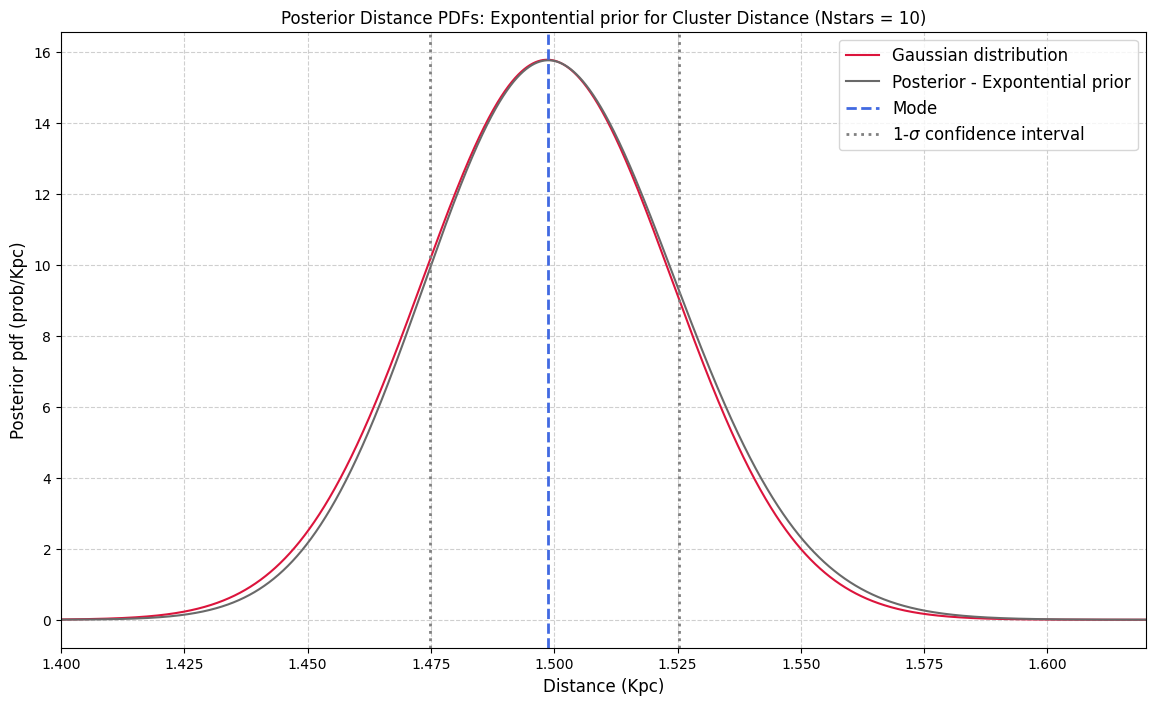

In [165]:
# Sample only 10 stars from the selected cluster
cluster_10 = stars[stars['Name'] == 'FoF_2117'].sample(n=10, random_state=50)

# Select the appropriate data 
plx_10 = cluster_10['Plx'].values
e_plx_10 = cluster_10['e_Plx'].values
stars_plx_10 = plx_10 + gaia_corr # Adding correction factor

# Define the distance grid
dist_arr_10 = np.linspace(1/ np.max(stars_plx_10), 1 / np.min(stars_plx_10), 10000)  # Distance in kpc

posterior_pdf_exp_10, int95_exp_10, max_likelihood_position_exp_10 = posterior_fun(stars_plx_10, e_plx_10, dist_arr_10, prior_dis = 'exp')

wtmean_10, wterr_10 = wt_mean_err(stars_plx_10, e_plx_10)
norm_values_10 = sps.norm.pdf(dist_arr_10, loc=1/wtmean_10, scale=wterr_10 / (wtmean_10 ** 2))
print("The weighted mean distance is:", 1/wtmean_10, u"\u00B1", wterr_10 / (wtmean_10 ** 2))

plt.figure(figsize=(14,8))
plt.plot(dist_arr_10, norm_values_10 , color='crimson', label='Gaussian distribution')
plt.plot(dist_arr_10, posterior_pdf_exp_10, color = 'dimgrey', label = 'Posterior - Expontential prior')
plt.axvline(max_likelihood_position_exp_10, linestyle='dashed', color='royalblue', linewidth=2, label = 'Mode')
plt.axvline(int95_exp_10[0],color='gray',linestyle='dotted', linewidth=2)
plt.axvline(int95_exp_10[1],color='gray',linestyle='dotted', linewidth=2, label = r'1-$\sigma$ confidence interval')
plt.xlabel('Distance (Kpc)',fontsize=12)
plt.ylabel(r'Posterior pdf (prob/Kpc)',fontsize=12)
plt.xlim(1.40, 1.62)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6) 
plt.title('Posterior Distance PDFs: Expontential prior for Cluster Distance (Nstars = 10)')
plt.show()



# Question 3

### Brief Explanation 
For the 3rd question of this assignment we used the radial stellar density profile with fitted data based on the King profile model simulated in the assignment 2, in order to prepare for the MCMC. The King model was modified in order to consider some plausible assumptions for the mass distribution of the cluster using the virial theorem:

$ M = \frac{2r_c <\sigma^2 _{pm}>}{3G} $ (2)

where $r_c$ is the core radius of the cluster and $ <\sigma^2 _{pm}>$ is the population mean of
the squared-velocity dispersion of the cluster stars which can be measured from the sample variance
of the cluster stars proper motions. Considering the above our new King model takes the arguments of just the parameters of the M (assuming that all the stars are 1solar mass as an initial value), rt, rho0(initial values from assignment 2), d (mode of distance from the posterior distribution as the intial value) and $ <\sigma^2 _{pm}>$ (calculated using the formula of teh given hint as an intial value). Inside the King model the equation 2 was implemented to approximate the cluster's core radius. During the fitting process, the values of the distance and the population mean of the squared velocity dispersion were fixed to ensure consistency. Moreover, the equation 2 was altered to the appropriate dimensions, dividing the r_c with d^3, and converting the core radius into arcsec. The king profile was firstly integrated over the radial area bins of the clusters. The lmfit package allowed us to calculate the residual values of the data points in order to incoporate them into a combined plot depicting the stellar density profile with the respective residuals plot and obtaining the MLEs for each parameters. 

Subsequently, we set the functions for the Markov Chain Monte Carlo. We modified the lmf_lsq_binresid function, using the chi squared statistic and returning the output directly by squaring and summing the residuals array as the log likelihood (L=-χ^2/2) with the log-priors of the parameters.The logarithm was used for the calculation of the posterior probability density function (PDF) to ensure numerical stability and to simplify the multiplication of probabilities into addition. From the output of the aforementioned function we estimated the posterior without dividing by the evidence and marginalizing, as the mcmc inherently simplifies these terms by exploring the parameter space efficiently and focusing on regions of higher posterior probability. This approach allows us to estimate the posterior distribution of parameters directly without explicitly normalizing the probability.

### Assumptions 
-  Bayesian inference was explicitly used to calculate the posterior distributions of the model parameters by combining the prior distributions with the likelihood derived from the data.
- Independence of priors.
- The prior can be used to constrain the ranges of allowed parameter values.
- The prior of M, rho0, rt are assumed to be uniform and all values within the specified ranges(all parameters are positive) are equally likely before any data is observed.
- The prior distribution of d was calculated from question 2 from the gaussian distrbution of d(considering that is identical with the bayesian posterior distribution).
- The prior of $<\sigma^2 _{pm}>$ was assumed as normal distribution, considering hint ii. using the central limit theorem and having a large  star sample helps as calculate the  $<\sigma^2 _{pm}>$ error from the .std() function.


### Results 
The results indicate a good fit of the King profile model to the radial stellar density data, as evidenced by the minimum chi-squared value of 15.22 for 23 degrees of freedom and a goodness-of-fit value of 0.887. The estimated parameters, provide physically plausible values for the cluster’s mass and density distribution. The squared velocity dispersion aligns with expectations from the Central Limit Theorem and the sample size, as calculated from the prior assumptions.
The results and overall fitting are consistent with those in Assignment 2, validating the modifications to the King model and its implementation in the MCMC framework.

In [ ]:
# From assignemnt 2, only the King model was modified here 

def King_profile(r, params):
    """
    Computes the stellar density based on the King profile model.

    The King profile is used to model the radial distribution of stellar density in star clusters. 
    It incorporates a core radius (rc), tidal radius (rt), and central density (rho0), along with a constant background density (c).

    Inputs:
    r : array-like
        Radial distances at which to evaluate the stellar density.
    params : dict-like
        A dictionary containing the model parameters:
        'M': Total mass of the cluster (in solar masses)
        'd': Distance to the cluster (in kpc)
        'sigma_pm_sq': Mean squared velocity dispersion ((km/s)^2)
        'rt': Tidal radius (in kpc)
        'rho0': Central stellar density
        'c': Constant background density

    Outout:
    array-like
        The computed stellar density at each radial distance r. For radii larger than the tidal radius rt, 
        the density is constant at the value of c. For radii smaller than rt, the density is computed using the King profile formula.

    """
    
    # Extract numerical values from params
    M = params['M']  # Mass of the cluster in solar masses
    d = params['d']  # Distance to the cluster in m
    sigma_pm2 = params['sigma_pm2']  # Mean squared velocity dispersion 
    rt = params['rt']  # Tidal radius in kpc
    rho0 = params['rho0']  # Central stellar density
    c = params['c']  # Constant background density

    # Gravitational constant 
    G = 6.67*10**(-11) #in m * (m/s)^2 * kg^(-1)
    
    # Convert sigma_pm2(mas/yr)^2 into (rad/s)2 
    sigma_pm2 = sigma_pm2 * (2.43*10**(-32)) #(rad/s)^2

    #Convert d(kpc) into m
    d = d * (3.08 * 10**19) #m

    # Calculate core radius rc from M, d, and sigma_pm2
    rc = (2 * G * M) / (3 * sigma_pm2 * d **3)  
    
    rc = rc * (180 * 3600) / np.pi # rc in arcsec

    return np.where(r <= rt, rho0 * ((1 / np.sqrt(1 + (r / rc)**2)) - (1 / np.sqrt(1 + (rt / rc)**2)))**2 + c, c)

def model_bin(xbins, model, params):
    '''General function for integrating the input model over bins defined by contiguous (no gaps) 
        bin edges, xbins.
       Inputs:
           xbins - x bin edges.
           model, params - the model name and associated Parameters object.
       Outputs:
           ymod - calculated counts-density model values for y-axis.'''

    ymod = np.zeros(len(xbins)-1)

    for i, xval in enumerate(xbins[:-1]):
        
        # Integrate the king profile function over the area of a radial bin 
        ymod[i], ymoderr = spint.quad(lambda x: 2 * np.pi * x * model(x, params),xbins[i],xbins[i+1])

        # Divide by the bin area 
        ymod[i] = ymod[i]/(np.pi * (xbins[i+1]**2 - xbins[i]**2))
        
    return ymod


def lmf_lsq_binresid(params,xdata,ydata,yerrs,model,output_resid=True):
    '''lmfit objective function to calculate and return residual array or model y-values for
        binned data where the xdata are the input bin edges and ydata are the densities (integral over bin
        divided by bin width).
        Inputs: params - name of lmfit Parameters object set up for the fit.
                xdata, ydata, yerrs - lists of 1-D arrays of x (must be bin edges not bin centres) 
                and y data and y-errors to be fitted.
                    E.g. for 2 data sets to be fitted simultaneously:
                        xdata = [x1,x2], ydata = [y1,y2], yerrs = [err1,err2], where x1, y1, err1
                        and x2, y2, err2 are the 'data', sets of 1-d arrays of length n1 (n1+1 for x2
                        since it is bin edges), n2 (n2+1 for x2) respectively, 
                        where n1 does not need to equal n2.
                    Note that a single data set should also be given via a list, i.e. xdata = [x1],...
                model - the name of the model function to be used (must take params as its input params and
                        return the model y-value array for a given x-value array).
                output_resid - Boolean set to True if the lmfit objective function (residuals) is
                        required output, otherwise a list of model y-value arrays (corresponding to the 
                        input x-data list) is returned.
        Output: if output_resid==True, returns a residual array of (y_i-y_model(x_i))/yerr_i which is
            concatenated into a single array for all input data errors (i.e. length is n1+n2 in 
            the example above). If output_resid==False, returns a list of y-model arrays (one per input x-array)'''
    if output_resid == True:
        for i, xvals in enumerate(xdata):  # loop through each input dataset and record residual array
            if i == 0:
                resid = (ydata[i]-model_bin(xdata[i],model,params))/yerrs[i]
            else:
                resid = np.append(resid,(ydata[i]-model_bin(xdata[i],model,params))/yerrs[i])
        return resid
    else:
        ymodel = []
        for i, xvals in enumerate(xdata): # record list of model y-value arrays, one per input dataset
            ymodel.append(model_bin(xdata[i],model,params))
        return ymodel
    
    

def goodness_fit(model, edges, density, yerr, params):              
    """
    Fits a given model to the provided data using the least-squares method, evaluates the goodness of fit, 
    and prints the optimized parameters with their uncertainties.

    Inputs:
    model : 
        The model function to fit.
    edges : array-like
        The bin edges for the radial distance data.
    density : array-like
        The observed stellar density values corresponding to the bin edges.
    yerr : array-like
        The errors associated with the density values.
    params : Parameters()
        The initial guesses and bounds for the model parameters. 
       

    Output:
    None
        This function prints the results of the fit, the minimum chi-squared value,
        degrees of freedom, the goodness-of-fit value,
        and the optimized parameter values and their uncertainties
    
    """
    output_resid = True
    xdata = [edges]
    ydata = [density]
    yerrs = [yerr]
    set_function = Minimizer(lmf_lsq_binresid, params, fcn_args=(xdata, ydata, yerrs, model, output_resid),nan_policy='omit')
    result = set_function.minimize(method = 'leastsq')

    print("Minimum Chi-squared = "+str(result.chisqr)+" for "+str(result.nfree)+" d.o.f.")
    print("The goodness of fit is: ",sps.chi2.sf(result.chisqr,df=result.nfree))

    # Print the fitted parameters
    for param_name, param in result.params.items():
        print(f"{param_name}: {param.value:.3e} ± {param.stderr if param.stderr is not None else 'N/A'}")
        
    return result, xdata, ydata, yerrs

def plot_spec_model(ebins,cdens,cdens_err,cdens_model):
    '''Plot the binned Stellar Density with the model as a histogram, and 
       data/model residuals.
       Inputs:
           ebins - energy bin edges.
           cdens, cdens_err - counts density and its error.
           cdens_model - model counts density.'''
    energies = (ebins[1:]+ebins[:-1])/2
    bwidths = np.diff(ebins)
    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,6),sharex=True,gridspec_kw={'height_ratios':[2,1]})
    fig.subplots_adjust(hspace=0)
    ax1.errorbar(energies, cdens, xerr=bwidths/2., yerr=cdens_err, fmt='o')
    model_hist, edges, patches = ax1.hist(energies, bins=ebins, weights=cdens_model, 
                                      density=False, histtype='step')
    ax2.errorbar(energies, cdens/cdens_model, xerr=bwidths/2., yerr=cdens_err/cdens_model, fmt='o')
    ax2.set_xlabel('Radial Distance (arcseconds)', fontsize=16)
    ax1.set_ylabel('Stellar Density (stars / arcsec²)', fontsize=14)
    ax2.set_ylabel("data/model", fontsize=14)
    ax2.axhline(1.0, color='r', linestyle='dotted', lw=2) 
    ax1.tick_params(labelsize=14)
    ax1.tick_params(axis="x",direction="in",which="both", length=4)
    ax2.tick_params(axis="x",which="both", length=4)
    ax2.tick_params(labelsize=14)
    ax1.set_yscale('log')
    ax1.set_xscale('log')
    ax2.set_xscale('log')
    ax1.get_yaxis().set_label_coords(-0.12,0.5)
    ax2.get_yaxis().set_label_coords(-0.12,0.5)
    ax2.set_xlim(ebins[0],ebins[-1]) 
    plt.show()

def histrebin(mininbin,counts,edges):

    '''Takes as input a minimum counts per bin and a histogram counts and bin edges, and combines 
       adjacent histogram bins as needed so that no bin has less than the required minimum.
       Inputs:
           mininbin - required minimum counts/bin.
           counts, edges - input histogram counts/bin and bin edges arrays.
       Outputs:
           counts2, edges2 - rebinned counts/bin and bin edges arrays'''
    
    edges2=np.zeros(1)
    counts2=np.zeros(1)
    i=0
    countsum=0
    firstbin_flag = 1
    edges2[0]=edges[0]
    for x in counts:
        countsum=countsum+x
        i=i+1
        if countsum >= mininbin and (sum(counts[i:]) >= mininbin or i == len(counts)):  # The sum over counts in 
            # remaining bins ensures that we are not left with a bin with counts less than our limit at the end.
            if firstbin_flag == 1: # if this is the first bin satisfying our requirement, 
                # do not append but replace bin 0 with countsum
                counts2[0]=countsum
                firstbin_flag = 0 # now we read the first bin we can switch this off
            else:
                counts2=np.append(counts2,countsum)
            edges2=np.append(edges2,edges[i])
            countsum=0   
                 
    return counts2, edges2

def cluster_hist(cluster_data):
    """
    Creates a histogram of stellar density as a function of radial separation.

    This function bins the radial separations of stars, computes the stellar density 
    in each bin, and calculates errors for the density and bin centers.

    Inputs:
    cluster_data : DataFrame
        Data containing the cluster information, including the radial separations
        of stars under the column 'Rad_Sep'.

    Output:
    density : array
        Stellar density in each radial bin.
    edges2 : array
        Edges of the bins used for the histogram.
    bin_centers : array
        Centers of the bins for plotting purposes.
    yerr : array
        Errors in the stellar density for each bin.
    xerr : array
        Errors in the bin positions (bin width/2).
    """

    # Define radial bins
    radial_bins = np.geomspace(cluster_data['Rad_Sep'].min(), cluster_data['Rad_Sep'].max(), num=60)

    # Create histogram for counts
    counts, edges = np.histogram(cluster_data['Rad_Sep'], bins=radial_bins)

    # Set minimum number of bins 
    mincounts = 20  
    counts2, edges2 = histrebin(mincounts, counts, edges)

    # Calculate areas of annuli
    area = np.pi * (edges2[1:] ** 2 - edges2[:-1] ** 2)

    # Stellar density
    density = counts2 / area

    # Calculate bin centers
    bin_centers = (edges2[:-1] + edges2[1:]) / 2

    # Calculate erros
    yerr = np.sqrt(counts2)/area

    xerr = (edges2[1:] - edges2[:-1]) / 2
    
    return density, edges2, bin_centers, yerr, xerr



In [ ]:
def King_profile_new(r, params):
    """
    Computes the stellar density based on the King profile model.

    The King profile is used to model the radial distribution of stellar density in star clusters. 
    It incorporates a core radius (rc), tidal radius (rt), and central density (rho0), along with a constant background density (c).

    Inputs:
    r : array-like
        Radial distances at which to evaluate the stellar density.
    params : dict-like
        A dictionary containing the model parameters:
        'M': Total mass of the cluster (in solar masses)
        'd': Distance to the cluster (in kpc)
        'sigma_pm_sq': Mean squared velocity dispersion ((km/s)^2)
        'rt': Tidal radius (in kpc)
        'rho0': Central stellar density
        'c': Constant background density

    Outout:
    array-like
        The computed stellar density at each radial distance r. For radii larger than the tidal radius rt, 
        the density is constant at the value of c. For radii smaller than rt, the density is computed using the King profile formula.

    """

    # c = 0 

    # Extract numerical values from params
    (rho0, rt, M, d, sigma_pm2) = params
    
    # Gravitational constant 
    G = 6.67*10**(-11) #in m * (m/s)^2 * kg^(-1)
    
    # Convert sigma_pm2(mas/yr)^2 into (rad/s)2 
    sigma_pm2 = sigma_pm2 * (2.43*10**(-32)) #(rad/s)^2

    #Convert d(kpc) into m
    d = d * (3.08 * 10**19) #m

    # Calculate core radius rc from M, d, and sigma_pm2
    rc = (2 * G * M) / (3 * sigma_pm2 * d **3)  # rc in m
    
    rc = rc * (180 * 3600) / np.pi

    return np.where(r <= rt, rho0 * ((1 / np.sqrt(1 + (r / rc)**2)) - (1 / np.sqrt(1 + (rt / rc)**2)))**2, 0)

def compute_sigma_pm_sq(cluster_data):
    """
    Computes the population variance of proper motions and its standard error.

    This function calculates the variance of the squared proper motions (in RA and DE)
    based on the given cluster data, using the sample mean and sample variance formulas.

    Input:
    cluster_data : DataFrame
        Data containing the cluster information with columns 'pmRA' and 'pmDE' for 
        the proper motions in Right Ascension (RA) and Declination (DE), respectively.

    Output:
    sigma2_pm : float
        The population variance of proper motions.
    sigma2_pm_err : float
        The standard error of the variance.
    """

    pm_ra = cluster_data['pmRA'].values
    pm_de = cluster_data['pmDE'].values

    # Compute sample means for RA and DE proper motions
    mean_pm_ra = np.mean(pm_ra)
    mean_pm_de = np.mean(pm_de)

    # Compute the variance based on the given formula
    sigma2_pm = np.sum((pm_ra - mean_pm_ra)**2 + (pm_de - mean_pm_de)**2) / (len(pm_ra) - 1)
    vars = ((pm_ra - mean_pm_ra)**2 + (pm_de - mean_pm_de)**2) / (len(pm_ra) - 1)
    
    # Compute the standard deviation error
    sigma2_pm_err = vars.std()

    return sigma2_pm, sigma2_pm_err

def Log_prior(params):
    """
    Calculates the logarithm of the prior probabilities for the given parameters.

    The prior probabilities are based on:
    - A Gaussian prior for distance, `d`.
    - A Gaussian prior for the squared proper motion variance, `sigma_pm2`.
    - A log-uniform prior for the mass, `M`.
    - Uniform priors for the central density, `rho0`, and the tidal radius, `rt`.

    Input:
    params : tuple
        A tuple of model parameters (rho0, rt, M, d, sigma_pm2), where:
        - rho0 : float
            Central stellar density.
        - rt : float
            Tidal radius of the cluster.
        - M : float
            Mass of the cluster (in solar masses).
        - d : float
            Distance to the cluster (in kpc).
        - sigma_pm2 : float
            Population variance of proper motions.

    Output:
    log_prior : float
        The logarithm of the total prior probability. If any parameter violates its prior,
        returns -inf (log(0)).
    """
    
    rho0, rt, M, d, sigma_pm2 = params

    sigma_pm_sq_obs, sigma_pm_sq_err = compute_sigma_pm_sq(cluster_data) 
    
    
    p_d = sps.norm.pdf(d, loc=1/wtmean, scale=wterr / (wtmean ** 2))
    if p_d == 0:
        return -np.inf
    else:
        logp_d = np.log(p_d)


    # Gaussian prior for sigma_pm_sq
    logp_sigma = -0.5 * ((sigma_pm2 - sigma_pm_sq_obs) / sigma_pm_sq_err) ** 2

    # Log-uniform prior for M
    logp_M = -np.inf if (M <= 0) else np.log(1 / M)
    
    # Log-uniform prior for rho0
    logp_rho0 = 0 if (0 <= rho0) else -np.inf

    # Log-uniform prior for rt
    logp_rt = 0 if (0 <= rt) else -np.inf

    return logp_d + logp_sigma + logp_M + logp_rho0 + logp_rt

def lmf_lsq_binresid_mod(params,xdata,ydata,yerrs,model,prior_model, output_resid=True):
    '''lmfit objective function to calculate and return residual array or model y-values for
        binned data where the xdata are the input bin edges and ydata are the densities (integral over bin
        divided by bin width).
        Inputs: params - name of lmfit Parameters object set up for the fit.
                xdata, ydata, yerrs - lists of 1-D arrays of x (must be bin edges not bin centres) 
                and y data and y-errors to be fitted.
                    E.g. for 2 data sets to be fitted simultaneously:
                        xdata = [x1,x2], ydata = [y1,y2], yerrs = [err1,err2], where x1, y1, err1
                        and x2, y2, err2 are the 'data', sets of 1-d arrays of length n1 (n1+1 for x2
                        since it is bin edges), n2 (n2+1 for x2) respectively, 
                        where n1 does not need to equal n2.
                    Note that a single data set should also be given via a list, i.e. xdata = [x1],...
                model - the name of the model function to be used (must take params as its input params and
                        return the model y-value array for a given x-value array).
                output_resid - Boolean set to True if the lmfit objective function (residuals) is
                        required output, otherwise a list of model y-value arrays (corresponding to the 
                        input x-data list) is returned.
    Output: if output_resid==True, returns a residual array of (y_i-y_model(x_i))/yerr_i which is
            concatenated into a single array for all input data errors (i.e. length is n1+n2 in 
            the example above). If output_resid==False, returns a list of y-model arrays (one per input x-array)'''
    if output_resid == True:
        for i, xvals in enumerate(xdata):  # loop through each input dataset and record residual array
            if i == 0:
                resid = (ydata[i]-model_bin(xdata[i],model,params))/yerrs[i]
            else:
                resid = np.append(resid,(ydata[i]-model_bin(xdata[i],model,params))/yerrs[i])
        
        return -0.5*np.sum(resid**2) + prior_model(params)

        #if not np.isfinite(likelihood):
        #    return -np.inf
        #else:
        #    return likelihood
    else:
        ymodel = []
        for i, xvals in enumerate(xdata): # record list of model y-value arrays, one per input dataset
            ymodel.append(model_bin(xdata[i],model,params))
        return ymodel



In [150]:

# Calculate <sigma_pm>^2
N = len(cluster_data)
RA_mean = cluster_data['pmRA'].mean()
DE_mean = cluster_data['pmDE'].mean()
    
# Compute variance terms of RA and DE
sigma_RA = ((cluster_data['pmRA'] - RA_mean) ** 2) / (N-1)
sigma_DE = ((cluster_data['pmDE'] - DE_mean) ** 2) / (N-1)
vars = sigma_RA + sigma_DE

sigma_pm2_mean = np.sum(vars)

# Calculate sigma errors
sigma_error = vars.std()

# Use posterior of d (Bayesian with expontential prior) to save MLE
prior_d, int95_exp, max_likelihood_position_exp = posterior_fun(stars_plx, e_plx, dist_arr, prior_dis = 'exp')


1-sigma interval on d = [1.55505191 1.56125402]
The maximum likelihood position is (Kpc): 1.558097996139528


Minimum Chi-squared = 15.220486149977113 for 23 d.o.f.
The goodness of fit is:  0.886557403668044
rho0: 9.141e-04 ± 4.17710866822197e-05
rt: 2.596e+03 ± 106.1751649279765
c: 0.000e+00 ± 0
d: 1.558e+00 ± 0
M: 7.167e+33 ± 4.928185889882722e+32
sigma_pm2: 3.996e-02 ± 0


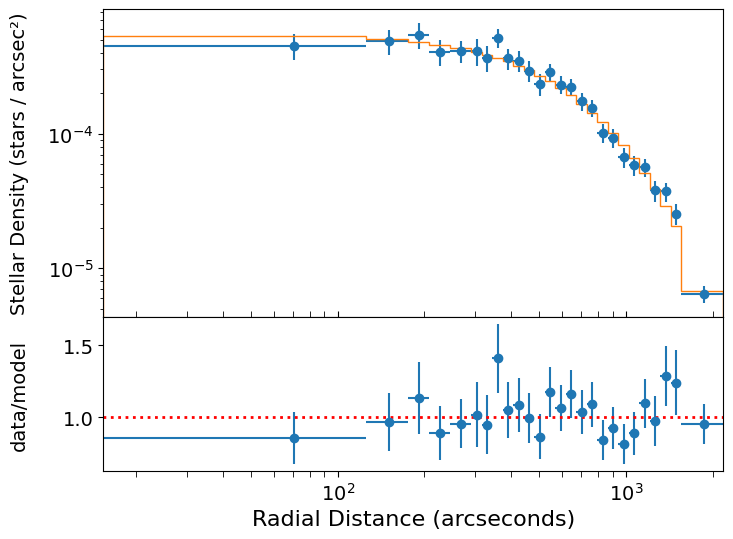

In [146]:
N_stars = len(plx)
M_sun = 1.98e30

params=Parameters()
params.add('rho0', value=0.01, min=0, max=0.1)
params.add('rt', value=2000, min=0, max=5000)
params.add('c', value=0, vary=False)
params.add('d', value=max_likelihood_position, vary = False)
params.add('M',  value=float(N_stars * M_sun), min=float(10**20), max=float(10**40))
params.add('sigma_pm2',  value=sigma_pm2_mean, vary=False )

# Calculate the mean x = RA and y = DE
mean_RA = cluster_data['RAdeg'].mean()
mean_DE = cluster_data['DEdeg'].mean()
                       
# Calculate the Radial Seperation and assign a new column into the DataFrame 
cluster_data = cluster_data.assign(Rad_Sep = 3600 * np.sqrt((cluster_data.RAdeg - mean_RA)**2 + (cluster_data.DEdeg - mean_DE)**2))

density, edges2, bin_centers, yerr, xerr = cluster_hist(cluster_data)

result, xdata, ydata, yerrs = goodness_fit(King_profile, edges2, density, yerr, params)

# Calculate the best-fitting model values, with the parameters of the best fit output
model_vals = lmf_lsq_binresid(result.params,xdata,ydata,yerrs,King_profile,output_resid=False)

# Plot the data and model and residuals
plot_spec_model(edges2,density,yerr,model_vals[0])



# Question 4

### Brief Explanation 
In this part of the assignment, we applied the Markov Chain Monte Carlo (MCMC) method to investigate the posterior distributions of the model parameters for the cluster, using suitable priors for each parameter, as stated above. The starting positions of the MCMC walkers were initialized near the maximum likelihood estimates (MLEs) derived from the King model fitting, with a slight random variation around these estimates. We employed 60 walkers to sample the 5-dimensional parameter space, with each walker taking 5000 steps to ensure thorough results. We calculated the log likelihood using the chi-squared statistic, along with log priors to assess the posterior probability density function. The chains for each parameter were visualized to check for convergence, and normalised density plot was conducted to confirm that there were no significant periodicities or biases in the sampling process.
In the end, we created a corner plot of the posterior distributions, which illustrated the confidence regions and quantiles (0.158, 0.50, and 0.84). The results yielded the MLEs and 1σ confidence intervals for each parameter, including the cluster mass M, which was expressed in physical units (kg). This approach enabled us to directly derive the posterior distributions of the parameters, utilizing the Bayesian framework to integrate prior knowledge and observational data.

### Assumptions 

- Bayesian inference was explicitly used to calculate the posterior distributions by combining the prior distributions of the parameters with the likelihood derived from the data.
- The walkers are assumed to move independently in the parameter space ensuring unbiased sampling.
- Priors are assumed to reflect our best knowledge or assumptions about the parameters before observing the data(all the priors were discussed in the previous question assumptions)
- The likelihood function accurately represents the probability of the observed data given the model from the chi-squared statistic.
- The posterior without explicitly marginalizing, it is assumed that the evidence term does not significantly impact the posterior shape in MCMC code.
- It is assumed that 60 walkers and 5000 steps are sufficient for comprehensive sampling of the parameter space. 


### Results 
- Trace plots

The parameter trace plots are created to make sure that our a priori distribution is well calibrated which is indicated by our parameters having sufficient state changes as the MCMC algorithm runs. The trace plots for rho0, rt, M, d and $ <\sigma^2 _{pm}>$ show a random walk behavior, without any apparent anomalies like flat sections. The chains thoroughly explore the parameter space multiple times, demonstrating effective mixing and convergence. Although there is some mild serial correlation between consecutive steps. Overall, the chains are adequately long and well-sampled, providing trustworthy posterior parameter estimates. The spread indicates the relative uncertainty for each parameter, with no significant irregularities detected. Provided the chains are many times this scale, the distribution will be well-sampled.

- Autocorrelation

One more important point is that the $ <\sigma^2 _{pm}>$ and rho0 power spectra at large chain lengths do not seem to completely flatten, but maintain a shallow slope. This indicates that they have still not yet sampled all the variance in the parameter distributions, which may be linked to the steep peaks appearing in the rho0 chains. The effect is small don't affect our results significantly, at least for estimating confidence intervals in the 1-sigma range.

- Corner plots

The corner plot illustrates the posterior distributions for the parameters rho0, rt, M, d, and $<\sigma^2 _{pm}>$. We discard the first 100 samples for each walker chain of samples, in order to avoid the burn-in region which will distort our results, even though there doesnt seem to appear any burn in region in the trace plots. The histograms along the diagonal show the marginalized posterior distributions, with the 16th and 84th percentiles (black dashed lines) representing the 1-sigma confidence intervals, and the blue lines indicating the initial MLE best-fit values for comparison with the sampled distributions, but we use mostly the default settings for corner.As we can see the central values are within the exceptable 1-sigma intervals making them a good fit of the data.  Most parameters exhibit Gaussian-like distributions with well-defined peaks near their medians, validating the MCMC chains' convergence. The contours help show you the 3D shape by marking rings where the posterior density is the same. Where the contours are closer together the density changes more rapidly. The overall shape tells us a bit about the correlation between the parameters. The contour plots reveal slight correlations, such as between rt (tidal radius) and M (mass), where the elliptical shapes suggest a positive correlation, while the rest of the parameters, show minimal correlations with nearly circular contours. The results demonstrate good agreement between the MLE values and posterior medians, while the MCMC approach provides a more detailed characterization, capturing uncertainties and correlations that the initial MLE analysis could not fully reveal. Notably, all the initial parameters calculated from the King model fitting are within the 1σ confidence intervals determined by the MCMC. This alignment reinforces the consistency between the least-squares fit and the Bayesian posterior inference, enhancing the robustness of the derived parameters.


In [ ]:
# Save best parameter list from the King model fitting 
best_par_list = []

for par in ['rho0','rt', 'M', 'd', 'sigma_pm2']:
    best_par_list.append(result.params[par].value)

best_par=np.array(best_par_list) # needs to be an array so we can use it for calculations
ndim, nwalkers = 5, 60  # The number of parameters and the number of walkers (we follow the 
# emcee example and use 100)
output_ll = True
pos = [best_par + 0.01*best_par*sps.norm.rvs(size=ndim) for i in range(nwalkers)]  # we spread the 
# walkers around the MLEs with a standard deviation equal to 1 per cent of the MLE value


In [148]:
model = King_profile_new

prior_model = Log_prior 

sampler = emcee.EnsembleSampler(nwalkers, 
                                ndim, 
                                lmf_lsq_binresid_mod, 
                                args=(xdata, ydata, yerrs, model, prior_model, output_ll),
                                pool=Pool())

sampler.run_mcmc(pos, 5000)

np.save('plexp1000_samplerchain',sampler.chain)

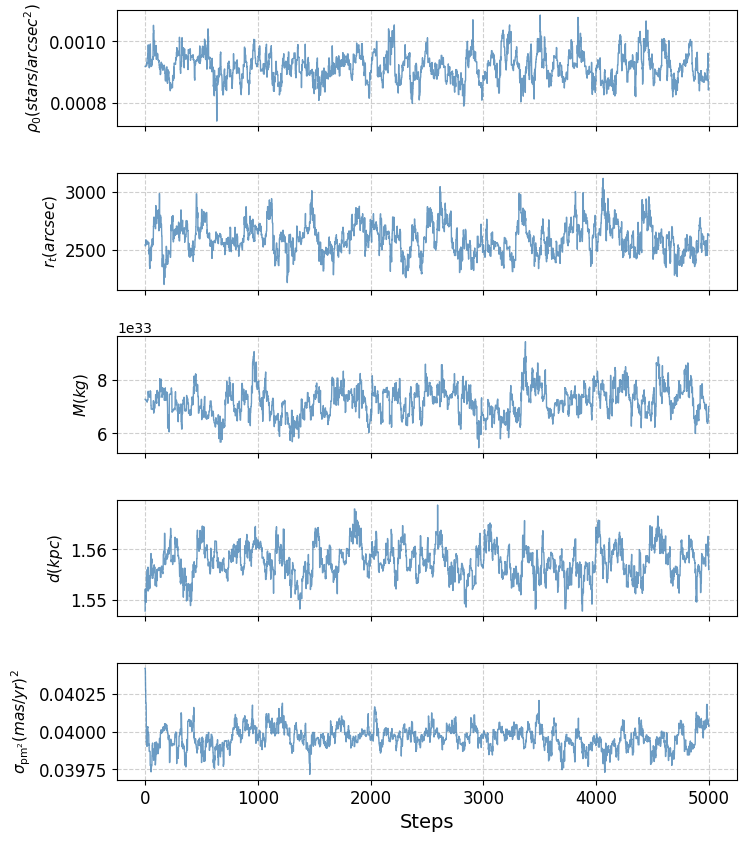

In [151]:

labels_list1 = [r'$\rho_0 (stars/arcsec^2)$', r'$r_t (arcsec)$', r'$M(kg)$', r'$d(kpc)$', r'$\sigma_{\mathrm{pm}^2}(mas/yr)^2 $'] # Use Unicode for subscripts for a cleaner look

nsteps = 10000  # Adjust to 1000 steps (as in your data visualization)
rng = np.random.default_rng()  # Set up a random number generator to select a random walker

fig, axes = plt.subplots(ndim, 1, figsize=(8, 10), sharex=True)
fig.subplots_adjust(hspace=0.4)  # Adjust spacing between subplots

# Iterate over dimensions to create subplots
for j in range(ndim):
    ax = axes[j]
    ax.plot(sampler.chain[rng.integers(nwalkers), :nsteps, j], color='steelblue', lw=1, alpha=0.8)
    ax.set_ylabel(labels_list1[j], fontsize=11)
    ax.grid(True, linestyle='--', alpha=0.6)  # Add gridlines
    ax.tick_params(axis='both', labelsize=12)  # Customize tick sizes
   

# Add a shared xlabel
axes[-1].set_xlabel('Steps', fontsize=14)

# Save and show the figure
plt.savefig('improved_singlechain_plexpcut_1000cts.png', dpi=300, bbox_inches='tight')
plt.show()


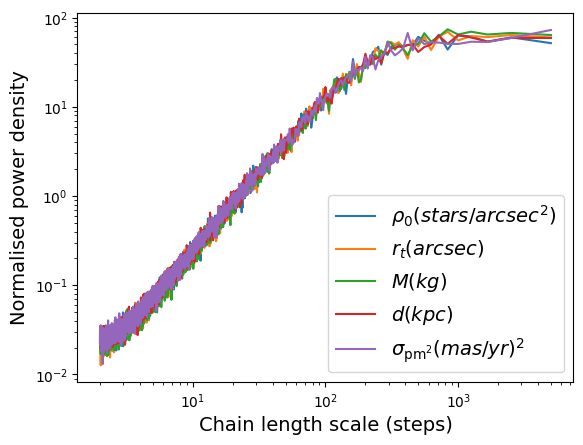

In [152]:

def plot_chains_powspec(chain_in,labels): 
    powspec = np.sum(np.abs(scipy.fft.fft(chain_in,axis=1))**2,axis=0)
    freq = scipy.fft.fftfreq(len(chain_in[0,:,0]))
    plt.figure()
    for i in range(ndim):
        plt.plot(1/freq[1:len(freq)//2],
                 powspec[1:len(freq)//2,i]/np.mean(powspec[1:len(freq)//2,i]),label=labels[i])
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel(r'Chain length scale (steps)', fontsize = 14)    
    plt.ylabel(r'Normalised power density', fontsize = 14)
    plt.legend(fontsize=14)
    plt.savefig('ep12_chains_powspec.png')
    plt.show()
    return

plot_chains_powspec(sampler.chain,labels_list1)

In [156]:
labels_list = ['rho0 (stars/arcsec^2)', 'rt (arcsec)', 'M(kg)', 'd(kpc)', 'sigma_pm^2(mas/yr)^2 '] # Use Unicode for subscripts for a cleaner look

flat_samples_full = sampler.get_chain(discard=100, flat=True)
print("Median and 1-sigma errors")
for i in range(ndim):
    mcmc = np.percentile(flat_samples_full[:, i], [15.85, 50, 84.15])
    q = np.diff(mcmc)
    txt = "{3} = {0:.3e} -{1:.3e}/+ {2:.3e}" # This formatting rounds to 3 decimal places.
    txt = txt.format(mcmc[1], q[0], q[1], labels_list[i])
    print(txt)

Median and 1-sigma errors
rho0 (stars/arcsec^2) = 9.168e-04 -5.154e-05/+ 5.206e-05
rt (arcsec) = 2.603e+03 -1.215e+02/+ 1.390e+02
M(kg) = 7.122e+33 -5.509e+32/+ 6.140e+32
d(kpc) = 1.558e+00 -3.201e-03/+ 3.175e-03
sigma_pm^2(mas/yr)^2  = 3.996e-02 -7.393e-05/+ 7.345e-05


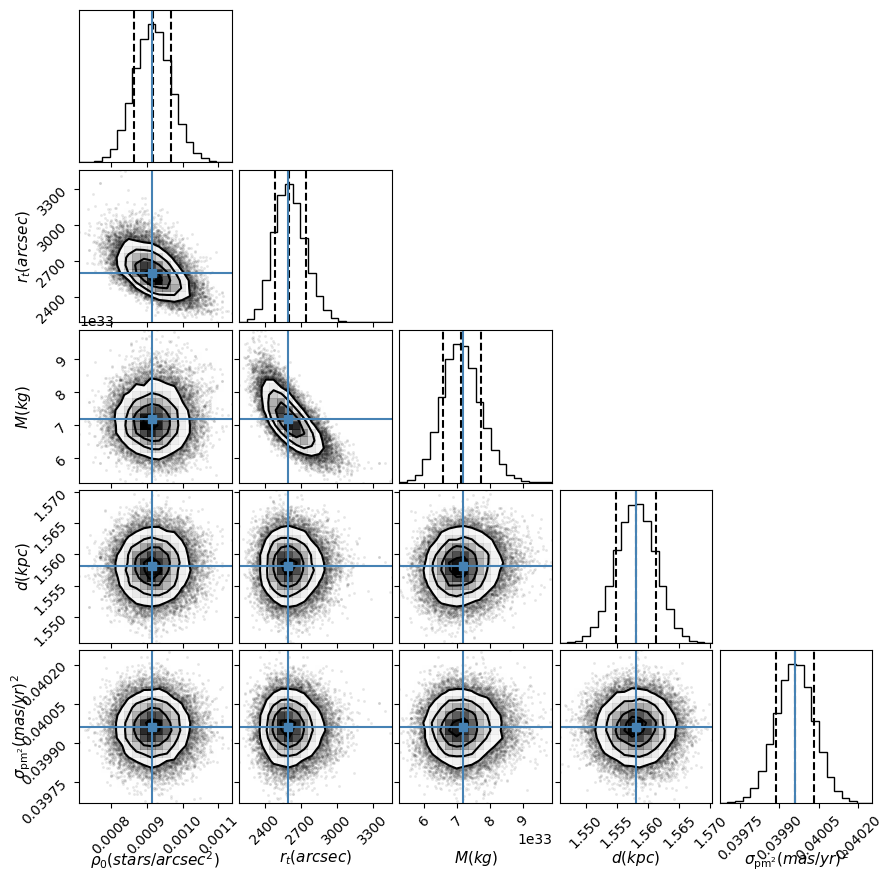

In [157]:
quantiles = [0.158, 0.50, 0.84]

# Plot a corner plot using thin=10 to reduce the density for visual appearance
flat_samples = sampler.get_chain(discard=500, thin=10, flat=True) 
fig = plt.figure(figsize=(9,9))
corner.corner(flat_samples, labels=labels_list1, label_kwargs={"fontsize": 11}, quantiles = quantiles, truths = best_par_list, fig =fig)
plt.savefig('ep12_corner_plexpcut_1000cts.png')
plt.show()